# Exercise 2: Regression in Keras
In this exercise, you will learn how to effectively use Keras to train neural network models. You will learn how to make your own Keras models, evaluate their performance, and see the different ways that models can overfit (and how to prevent them). Elements of this exercise have been adapted from the Keras tutorials for Keras.

This notebook contains many sections that are filled out for you and many that you will need to fill out to complete the exercise (marked in <font color='red'>RED</font>). You are finished when "Restarting and Run All Cells" executes the entire notebook without producing any errors. Do not remove assert statements.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras import optimizers as opt
from keras import Sequential
from keras import layers
from time import perf_counter
from math import isclose
import pandas as pd
import numpy as np
import warnings
import keras
np.random.seed(1)

Using TensorFlow backend.


## Load Data
We are going to use the [Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

First step is to download and cache it locally

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

Now, we read in the data using Pandas. As the dataset lacks headers, we have to make them ourselves

In [3]:
with open(dataset_path) as fp:
    for i in range(5):
        print(fp.readline().strip())

18.0   8   307.0      130.0      3504.      12.0   70  1	"chevrolet chevelle malibu"
15.0   8   350.0      165.0      3693.      11.5   70  1	"buick skylark 320"
18.0   8   318.0      150.0      3436.      11.0   70  1	"plymouth satellite"
16.0   8   304.0      150.0      3433.      12.0   70  1	"amc rebel sst"
17.0   8   302.0      140.0      3449.      10.5   70  1	"ford torino"


In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
data = pd.read_csv(dataset_path, names=column_names,
                   na_values = "?", comment='\t',
                   sep=" ", skipinitialspace=True)
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


The data has some missing values, and we'll just remove them

In [5]:
data.dropna(inplace=True)
print(f'Total number of entries: {len(data)}')

Total number of entries: 392


This is far from "big data", but will help us learn Keras with minimal waiting around for computations to finish

### Preprocessing
There are a few things we need to deal with about the data first to make it more accessible to machine learning.

The first is the "Origin" column, which is a categorical variable expressed as a list of numbers. 
Categorial variables expressed this way cause problems with machine learning because the ordering of numbers suggest cardinality that does not exist
(i.e., Origin "1" is not less than Origin "2").
We will use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to remove this false ordering.

In [6]:
new_origin = pd.get_dummies(data['Origin'], prefix='Origin')
new_origin.head()

,Origin_1,Origin_2,Origin_3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


Replace the origin column with these new columns

*Pro Tip*: [Pandas](https://pandas.pydata.org/) makes working with tabular data in Python very easy. If you are about to write a loop to operate on tabular data, check to see if Pandas already has a function for what you're trying to do. Pandas makes your code much faster and easier to read/maintain. Start with the excellent [10 Minutes to Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html).

In [7]:
data = pd.concat([data, new_origin], axis=1)

In [8]:
data.drop('Origin', axis=1, inplace=True)

In [9]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


We now are going to mark which columns are inputs and outputs

In [10]:
y_col = 'MPG'
X_cols = data.columns[1:]

Output is "MPG" and input is anything except MPG

Another trick needed for training a Neural Network is that the input values should all be the same order of magnitude. 
As shown above, our data is not. So, we will normalize the datasets

In [11]:
data[X_cols] = data[X_cols].apply(lambda x: (x - x.mean()) / x.std())

In [12]:
data.head(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,1.482053,1.075915,0.663285,0.619748,-1.283618,-1.623241,0.773608,-0.457538,-0.501749
1,15.0,1.482053,1.486832,1.572585,0.842258,-1.464852,-1.623241,0.773608,-0.457538,-0.501749


Our data is now ready for training.
A best practice for evaluating neural networks is to split data into a training and validation sets.
When comparing different machine learning models, you should test them against data that was neither used to train the model nor select the hyperparameters of the model - the "validation set".

In [13]:
train_data, valid_data = train_test_split(data, test_size=0.1)
print(f'Training data has {len(train_data)} entries')
print(f'Validation data has {len(valid_data)} entries')

Training data has 352 entries
Validation data has 40 entries


## Quick Tutorial: Working with Keras
Building Keras models is decomposed into three different phases: defining the architecture, setting the optimizer, and training the model. We will go through each step independentally.

### Defining an Architecture
Keras provides a wide variety of layers that can be combined together to form complicated networks.
We are only going to focus on the [Sequential](https://keras.io/getting-started/sequential-model-guide/) type of model for simplicity, 
but you will get to make complicated models with branches in the Generative models session later today.

The Sequential model takes a list of layers to generate combine in to a single model.
The first element must specify the shape of the input data, which is the number of features in this case.
The last element defines the shape of the outputs and must allow for the outputs to output on the entire range of the data.
`linear` is a good choice for regression problems

In [14]:
model = Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(X_cols),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

Taking a look at the network we created

In [15]:
print(f'Shape of the input: {model.input_shape}')
print(f'Shape of the output: {model.output_shape}')

Shape of the input: (None, 9)
Shape of the output: (None, 1)


It has an input shape of $N \times 9$, where $N$ can be any number of training entries, and $N \times 1$ outputs (i.e., just MPG)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


The model has 5 layers: an input layer (not shown), 2 hidden layers, and an output layer. 

#### Concept Review! How do we get 4865 parameters?
Remember our simple neural network from the lecture:

<img width=320px src="./img/simple-mlp.png"/>

_First Hidden Layer_: Each input node is connected to each node in the first hidden layer (i.e., the network is "fully connected"): $([\text{9 Inputs}] + [\text{1 Bias per Hidden Node}]) \times [\text{64 Hidden Nodes}] = 640\text{ parameters}$

_Second Hidden Layer_: Each node in the first hidden layer is connected to each node in the second hidden layer: $([\text{64 hidden nodes}] + [\text{1 Bias per Hidden Node}]) \times [\text{64 Hidden Nodes}] = 4160\text{ parameters}$

_Output Layer_: Each second hidden layer node is connected to the output node and that output node has a bias term: $[\text{64 hidden nodes}] + [\text{1 Bias}] = 65\text{ parameters}$


### Training a Model
The first step to train a model is to "compile" it.
Compiling defines the optimizer and the loss function for the network.

In [17]:
model.compile('adam', loss='mean_squared_error')

We compile with the Adam optimizer and using a mean squared error loss.
Note that you can define more settings for these optimizers by creating the optimizer as an object.

In [18]:
adam = keras.optimizers.Adam(lr=1e-3)
model.compile(adam, loss=keras.metrics.mean_squared_error)

The model is ready to be trained once you compile it.

The `fit` operation, like its analogue in scikit-learn, takes the inputs and outputs for the training data as arguments.
It also has many other options specific to neural networks, such as the "batch size" (see later module) and a "validation split." 

Validation sets are a very important tool in Neural Networks as they help determine if the model is overfitting during the training process.

In [19]:
history = model.fit(train_data[X_cols], train_data[y_col], batch_size=32, validation_split=0.1, epochs=8)

Train on 316 samples, validate on 36 samples
Epoch 1/8
316/316 [==============================] - 1s 4ms/step - loss: 594.1407 - val_loss: 586.3699
Epoch 2/8
316/316 [==============================] - 0s 130us/step - loss: 554.9096 - val_loss: 546.3172
Epoch 3/8
316/316 [==============================] - 0s 117us/step - loss: 510.8415 - val_loss: 497.8590
Epoch 4/8
316/316 [==============================] - 0s 123us/step - loss: 456.4339 - val_loss: 436.4495
Epoch 5/8
316/316 [==============================] - 0s 130us/step - loss: 389.3270 - val_loss: 360.2170
Epoch 6/8
316/316 [==============================] - 0s 127us/step - loss: 308.6936 - val_loss: 272.9400
Epoch 7/8
316/316 [==============================] - 0s 120us/step - loss: 223.2703 - val_loss: 181.3931
Epoch 8/8
316/316 [==============================] - 0s 139us/step - loss: 144.4228 - val_loss: 100.2411


The `history` object returned by the fit function contains details about the training process.

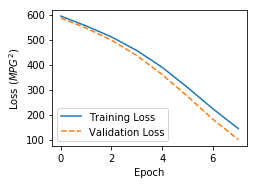

In [20]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history['loss'], label='Training Loss')
ax.plot(history.epoch, history.history['val_loss'], label='Validation Loss', linestyle='--')

fig.set_size_inches(3.5, 2.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss ($MPG^2$)')
ax.legend()

The loss for both the training data and the validation are both decreasing with epoch, which means our model is training correctly!

### Running the Model
Now that our model is trained, we can use it to predict the properties of the validation set we held out with the predict option.

In [21]:
pred_y = model.predict(valid_data[X_cols])

Text(0.5, 0, 'Predicted MPG')

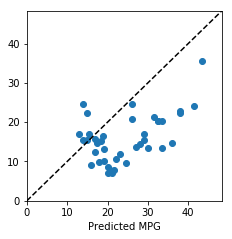

In [22]:
fig, ax = plt.subplots()

ax.scatter(valid_data[y_col], pred_y)

ax.set_xlim(0, max(valid_data[y_col].max(), pred_y.max()) + 5)
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

fig.set_size_inches(3.5, 3.5)
ax.set_xlabel('Actual MPG')
ax.set_xlabel('Predicted MPG')

Admittedly, the fitness is not very good. But, we only trained for 8 epochs.

## <font color='red'>Part 1: Overfitting a Neural Network</font>
A key problem with neural networks is that the more you train them, the more likely they are to become overfit.
In this part, we need you to create a neural network and overfit it.

<font color='red'>Step 1: Make a neural network with 3 hidden layers of 128 elements per hidden layer each and ReLU activations.</font>

In [24]:
assert model.count_params() == 34433

<font color='red'>Fit the model with a batch size of 32 for 1024 epochs with a hold out set of 10%. Use Adam with the default settings and mean squared error loss. Save the history as a variable named `history`</font>

*Pro Tip*: Keras produces a lot of status messages with its default `verbose` setting of the `fit` function. Consider using `verbose=0` to turn it off if that bothers you.

Plot the loss as a function of the number of epochs

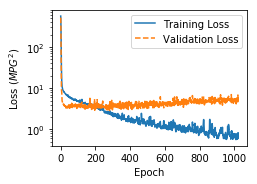

In [27]:
fig, ax = plt.subplots()

ax.semilogy(history.epoch, history.history['loss'], label='Training Loss')
ax.plot(history.epoch, history.history['val_loss'], label='Validation Loss', linestyle='--')

fig.set_size_inches(3.5, 2.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss ($MPG^2$)')
ax.legend()

Note how the validation loss stops decreasing around the 50th epoch and then increases. 
This is overfitting.
The network is continuing to get better at predicting the training data at the expense of being generalizable to other data

In [28]:
pred_y = model.predict(valid_data[X_cols])
overfit_score = mean_absolute_error(valid_data[y_col], pred_y)
print(f'Mean absolute error on held-out set: {overfit_score : 0.2f} MPG')

Mean absolute error on held-out set:  1.96 MPG


Text(0, 0.5, 'Predicted MPG')

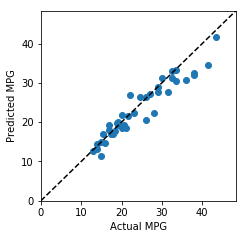

In [29]:
fig, ax = plt.subplots()

ax.scatter(valid_data[y_col], pred_y)

ax.set_xlim(0, max(valid_data[y_col].max(), pred_y.max()) + 5)
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

fig.set_size_inches(3.5, 3.5)
ax.set_xlabel('Actual MPG')
ax.set_ylabel('Predicted MPG')

The model does predict better than when we trained with only 8 epochs, but we can do better

## <font color='red'>Part 2: Preventing Overfitting with Early Stopping</font>
Early stopping is the idea that you detect when the error on the validation set is increasing and roll back to the network state with the best valiation error.

#### Quick Tutorial: Pre-trained Models
If you were to call the `fit` method again, the Keras model will resume training from its previous state.
This is a nice feature if you need to restart a training from a saved checkpoint or using the weights from another model for pretraining.
However, it interferes with the lesson on early stopping we want here.

So, we are going to make a new model before training.
To make this more convenient, we are going to make a function that generates a Keras model so to avoid having to write out the architecture each time.

*Pro Tip*: Making these "model building functions" can save you a lot of time when testing new architectures.

In [30]:
def build_model(n_layers=3, hidden_size=128):
    model = Sequential([layers.Dense(hidden_size, activation='relu', input_shape=(len(X_cols),))])
    
    for i in range(n_layers-1):
        model.add(layers.Dense(hidden_size, activation='relu'))
        
    model.add(layers.Dense(1, activation='linear'))
    return model

In [31]:
model = build_model()

In [32]:
model.compile('adam', 'mean_squared_error')

### Creating the Callback
Keras implement early stopping using a "callback."
Callback functions by performing an operation (e.g., assessing validation loss) at different points of the model training.
In our case, we will use the [`EarlyStopping`](https://keras.io/callbacks/#earlystopping) callback, which is one of many [available in Keras](https://keras.io/callbacks/)

In [33]:
callbacks = [keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25)]

The callback we defined will stop only if the validation loss does not improve after 25 epochs and will restore the state of the model at the point with lowest loss. We use the callbacks when calling the fit operation.

<font color='red'>Train the model using the same batch size, but now add the early-stopping callback. Store the result in `history`

In [ ]:
## HERE

The following cells will plot your results

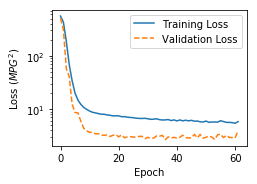

In [35]:
fig, ax = plt.subplots()

ax.semilogy(history.epoch, history.history['loss'], label='Training Loss')
ax.plot(history.epoch, history.history['val_loss'], label='Validation Loss', linestyle='--')

fig.set_size_inches(3.5, 2.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss ($MPG^2$)')
ax.legend()

The model now stops training at around 60 epochs.

In [36]:
assert len(history.epoch) < 256  # Model should stop training before 256 epochs

In [37]:
pred_y = model.predict(valid_data[X_cols])
earlystop_score = mean_absolute_error(valid_data[y_col], pred_y)
print(f'Mean absolute error on held-out set: {earlystop_score : 0.2f} MPG')

Mean absolute error on held-out set:  1.61 MPG


In [38]:
assert earlystop_score < overfit_score

Text(0, 0.5, 'Predicted MPG')

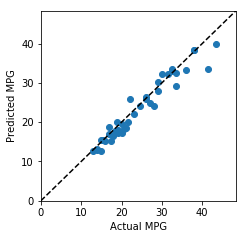

In [39]:
fig, ax = plt.subplots()

ax.scatter(valid_data[y_col], pred_y)

ax.set_xlim(0, max(valid_data[y_col].max(), pred_y.max()) + 5)
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

fig.set_size_inches(3.5, 3.5)
ax.set_xlabel('Actual MPG')
ax.set_ylabel('Predicted MPG')

The performance should be better than when you ran the network to its full number of epochs.

Early stopping is one of the many approaches to preventing overfitting. Some other techniques include:

- Reduce the model complexity
- Employ [Dropout](https://keras.io/layers/core/#dropout) layers, which randomly drop connections in the neural network during training. 
- Using [regularization](https://keras.io/regularizers/), which ensures the weights do not become too large

### <font color='red'>Part 3: Learning Rates and Batch Sizes</font>
The learning rate and batch sizes both control how the weights of the network are updated during training. 
Learning rate corresponds to the size of updates that are used when training the network, and batch size determines how many training entries are used to determine the direction of the update.
These numbers are important to be able to tune as they control how quickly a network trains and, potentially, how accurate the resulting model will be.

First we create Callback tool to track elapsed time, etc.

In [40]:
class PerformanceCallback(keras.callbacks.Callback):
    
    def __init__(self):
        self.start_time = None
        self.grad_updates = None
    
    def on_train_begin(self, logs=None):
        self.start_time = perf_counter()
        self.grad_updates = 0
        
    def on_batch_begin(self, batch, logs=None):
        self.grad_updates += 1
        
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            logs['elapsed_time'] = perf_counter() - self.start_time
            logs['grad_updates'] = self.grad_updates
perf = PerformanceCallback()

In [41]:
callbacks = [perf]

### Exploring the Effect of Batch Size
Here, we do a gradient update for each training entry. We are not using a validation set, as the point of this exercise is to see the training accuracy change

In [42]:
model = build_model()  # Remember to reset the model!
model.compile('adam', 'mean_squared_error')
b1_history = model.fit(train_data[X_cols], train_data[y_col], batch_size=1, callbacks=callbacks, verbose=0, epochs=16)

The history now contains elapsed time

In [43]:
b1_history.history.keys()

dict_keys(['loss', 'elapsed_time', 'grad_updates'])

<font color='red'>Run a batch size of 32, and compare the results in both the learning rate over epochs and over time

You should find that the model with the small batch size reaches low losses in fewer epochs, but that it also takes much longer to train.
Two factors make this model longer to train:

1. The small batch size is doing a larger number of gradient updates (i.e., more work)
2. The GPU is not fully utilized by a batch size of 1.

Regarding point 2: Modern CPUs and GPUs perform array/vector calculations in parallel. For example, multiple multiplication and addition operations of each matrix multiplication during nueral network training are performed at the same time. GPUs, in particular, posses the ability to do thousands of operations concurrently and, therefore, require large matrices to fully utilize. Practically, this means you need larger batch sizes.

To put some hard numbers: A GTX 670 GPU performs 240 gradient updates per second with a batch size of 1 and 220 per second with a batch size of 32, despite the "math operations per gradient update" being roughly 32x larger.

### <font color='red'>Explore Learning Rate</font>

Learning rate is another key parameter to adjust. Train a model with a very large learning rate (1e10) and a very small one (1e-10). What happens? How can you explain this?